In [38]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import jiwer
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

BATCH_SIZE = 128
char_to_num = {char: idx + 1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
char_to_num['<PAD>'] = 0
num_to_char = {v: k for k, v in char_to_num.items()}

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

pd.options.display.float_format = '{:.2f}'.format

In [163]:
def create_dataset_with_indices(X, y, indices, batch_size=BATCH_SIZE):
    
    def generator():
        for i in range(len(X)):
            yield X[i].astype(np.float32), y[i].astype(np.int32)
    
    output_signature = (
        tf.TensorSpec(shape=(None, X[0].shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    
    dataset = dataset.padded_batch(
        batch_size=batch_size,
        padded_shapes=([None, X[0].shape[1]], [None]),
        padding_values=(0.0, 0),
        drop_remainder=False
    )
    
    return dataset, indices

def predict_with_indices(test_dataset, model, indices, num_to_char):
    
    def decode_greedy(sequence, pred=True):
        if pred:
            logits = tf.transpose(sequence, [1, 0, 2])
            logits = tf.cast(logits, tf.float32)
            
            batch_size = sequence.shape[0]
            seq_length = tf.constant([logits.shape[0]] * batch_size, dtype=tf.int32)
            
            decoded, _ = tf.nn.ctc_greedy_decoder(
                inputs=logits,
                sequence_length=seq_length,
                merge_repeated=True,
                blank_index=0
            )
            
            decoded_dense = tf.sparse.to_dense(decoded[0])
            return decoded_dense
        else:
            return sequence
    
    def sequence_to_text(sequence, num_to_char):
        decoded_chars = []
        
        for idx in sequence.numpy():
            if idx == 0:
                continue
            char = num_to_char.get(idx, '')
            if char != '<PAD>' and char != '':
                decoded_chars.append(char)
        
        text = ''.join(decoded_chars)
        return ' '.join(text.split())
    
    results = {}
    sample_idx = 0
    expected_samples = len(indices)
    
    for batch_idx, (data, label) in enumerate(test_dataset):
        batch_size = data.shape[0]
        
        if sample_idx >= expected_samples:
            break
            
        pred = model.predict(data, verbose=False)
        decoded_pred_batch = decode_greedy(pred, pred=True)
        decoded_label_batch = decode_greedy(label, pred=False)
        
        for i in range(batch_size):
            if sample_idx >= expected_samples:
                break
                
            single_pred = decoded_pred_batch[i]
            single_label = decoded_label_batch[i]
            
            decoded_label = sequence_to_text(single_label, num_to_char)
            decoded_pred = sequence_to_text(single_pred, num_to_char)
            
            cer_value = jiwer.cer(decoded_label, decoded_pred)
            wer_value = jiwer.wer(decoded_label, decoded_pred)
            
            results[indices[sample_idx]] = {
                'true_label': decoded_label,
                'prediction': decoded_pred,
                'cer': cer_value,
                'wer': wer_value
            }
            
            sample_idx += 1
        
        if batch_idx % 50 == 0:
            print(f"Proceeded {sample_idx}/{expected_samples} samples (batch {batch_idx})")
    
    return results

def analyze_results_by_accent(results, test_df):
    
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df.index.name = 'df_index'
    
    merged_df = test_df.join(results_df, how='inner')
    # merged_df = test_df.merge(results_df, how='inner', left_on="clean_sentence", right_on="true_label")
    
    analysis_results = {}
    
    for accent in merged_df['accents'].unique():
        accent_data = merged_df[merged_df['accents'] == accent]
        
        cer_values = accent_data['cer'].values
        wer_values = accent_data['wer'].values
        
        analysis_results[accent] = {
            'N_samples': len(accent_data),
            'CER': cer_values.mean(),
            'WER': wer_values.mean(),
            'CER_std': cer_values.std(),
            'WER_std': wer_values.std(),
            '% no error': sum(cer_values == 0) / len(accent_data),
            '% error': sum(cer_values > 0) / len(accent_data),
            'perfect_predictions': sum(cer_values == 0),
            'min_CER': cer_values.min(),
            'max_CER': cer_values.max(),
            'min_WER': wer_values.min(),
            'max_WER': wer_values.max()
        }
    
    analysis_df = pd.DataFrame.from_dict(analysis_results, orient='index')
    analysis_df = analysis_df.sort_values(by='N_samples', ascending=False)
    analysis_df['N_samples'] = analysis_df['N_samples'].astype(int)
    analysis_df['perfect_predictions'] = analysis_df['perfect_predictions'].astype(int)
    
    return analysis_df, merged_df

def show_prediction_examples(merged_results, random_state=123):
    
    import random
    random.seed(random_state)
    np.random.seed(random_state)
    
    ranges = [
        (0, 0.01, 4, "CER = 0 (very good)"),
        (0.01, 0.1, 4, "CER < 0.1 (good)"),
        (0.1, 0.2, 3, "CER 0.1-0.2 (average)"), 
        (0.2, 0.5, 3, "CER 0.2-0.5 (weak)"),
        (0.5, 1.0, 3, "CER > 0.5 (very weak)")
    ]
    
    all_examples = []
    
    for cer_min, cer_max, n_samples, range_name in ranges:
        if cer_max == 1.0:
            subset = merged_results[merged_results['cer'] >= cer_min]
        else:
            subset = merged_results[(merged_results['cer'] >= cer_min) & (merged_results['cer'] < cer_max)]
    
        n_to_sample = min(n_samples, len(subset))
        examples = subset.sample(n_to_sample, random_state=random_state)
        
        print(f"\n🔍 {range_name} ({len(subset)} samples):")
        print("=" * 60)
        
        for idx, row in examples.iterrows():
            print(f"True: {row['true_label']}")
            print(f"Pred: {row['prediction']}")
            print(f"CER: {row['cer']:.3f}")
            
            accent = row['accents']
            if len(accent) > 50:
                accent = accent[:50] + "..."
            print(f"Accent: {accent}")
            
            print("-" * 40)

def plot_cer_errors(analysis_df, merged_df, threshold1=0.1, threshold2=0.2, legend=True, figsize=(20, 10)):
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    
    sorted_accents = analysis_df.sort_values('N_samples', ascending=False)
    
    accent_names = []
    cer_below_10 = []
    cer_10_to_20 = []
    cer_above_20 = []
    
    for accent in sorted_accents.index:
        accent_data = merged_df[merged_df['accents'] == accent]
        cer_values = accent_data['cer'].values
        
        below_10_count = sum(cer_values < threshold1)
        between_10_20_count = sum((cer_values >= threshold1) & (cer_values < threshold2))
        above_20_count = sum(cer_values >= threshold2)
        
        accent_names.append(accent)
        cer_below_10.append(below_10_count)
        cer_10_to_20.append(between_10_20_count)
        cer_above_20.append(above_20_count)
    
    x_pos = range(len(accent_names))
    
    color_excellent = '#2E8B57'
    color_good = '#2E86AB'
    color_poor = '#C73E1D'
    
    bars1 = ax.bar(x_pos, cer_below_10, 
                   color=color_excellent, alpha=0.8, 
                   label=f'CER < {threshold1*100:.0f}%')
    
    bars2 = ax.bar(x_pos, cer_10_to_20, 
                   bottom=cer_below_10,
                   color=color_good, alpha=0.8, 
                   label=f'{threshold1*100:.0f}% ≤ CER < {threshold2*100:.0f}%')
    
    bars3 = ax.bar(x_pos, cer_above_20, 
                   bottom=[b10 + b1020 for b10, b1020 in zip(cer_below_10, cer_10_to_20)],
                   color=color_poor, alpha=0.8, 
                   label=f'CER ≥ {threshold2*100:.0f}%')
    
    ax.set_xlabel('Accents', fontsize=14, fontweight='bold')
    ax.set_ylabel('Num samples', fontsize=14, fontweight='bold')
    ax.set_title(f'CER: <{threshold1*100:.0f}% vs {threshold1*100:.0f}%-{threshold2*100:.0f}% vs ≥{threshold2*100:.0f}%', 
                 fontsize=16, fontweight='bold')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(accent_names, rotation=45, ha='right', fontsize=12)
    if legend:
        ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    total_samples = [b10 + b1020 + b20 for b10, b1020, b20 in zip(cer_below_10, cer_10_to_20, cer_above_20)]
    
    for i, (total, below_10, between_10_20, above_20) in enumerate(zip(total_samples, cer_below_10, cer_10_to_20, cer_above_20)):
        ax.text(i, total + max(total_samples) * 0.01, f'{total}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        if below_10 > 0:
            percentage = (below_10 / total) * 100
            ax.text(i, below_10/2, f'{percentage:.1f}%', 
                    ha='center', va='center', fontsize=11, 
                    color='white', fontweight='bold')
        
        if between_10_20 > 0:
            percentage = (between_10_20 / total) * 100
            ax.text(i, below_10 + between_10_20/2, f'{percentage:.1f}%', 
                    ha='center', va='center', fontsize=11, 
                    color='white', fontweight='bold')
        
        if above_20 > 0:
            percentage = (above_20 / total) * 100
            ax.text(i, below_10 + between_10_20 + above_20/2, f'{percentage:.1f}%', 
                    ha='center', va='center', fontsize=11, 
                    color='white', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    stats_df = pd.DataFrame({
        'Accent': accent_names,
        'Total_samples': total_samples,
        'CER_below_10%': cer_below_10,
        'CER_10_to_20%': cer_10_to_20,
        'CER_above_20%': cer_above_20,
        'Percent_below_10%': [(below/total)*100 for below, total in zip(cer_below_10, total_samples)],
        'Percent_10_to_20%': [(between/total)*100 for between, total in zip(cer_10_to_20, total_samples)],
        'Percent_above_20%': [(above/total)*100 for above, total in zip(cer_above_20, total_samples)]
    })
    
    return stats_df


def plot_cer_distributions(merged_df, analysis_df, title1='CER distributon - Top 10 accents'):
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    top_accents = analysis_df.nsmallest(10, 'CER').index.tolist()
    data_for_plot = merged_df[merged_df['accents'].isin(top_accents)]
    
    import matplotlib.colors as mcolors
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    for i, accent in enumerate(top_accents):
        accent_data = data_for_plot[data_for_plot['accents'] == accent]
        sns.kdeplot(
            data=accent_data, 
            x='cer', 
            ax=ax1,
            fill=True, 
            alpha=0.3,
            linewidth=2,
            label=accent,
            color=colors[i % len(colors)]
        )
    
    ax1.set_xlabel('CER', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Density', fontsize=14, fontweight='bold')
    ax1.set_title(title1, fontsize=16, fontweight='bold')
    
    ax1.legend(title='Accents', title_fontsize=12, fontsize=10, 
              loc='upper right', frameon=True, fancybox=True, shadow=True)
    ax1.grid(True, alpha=0.3)
    
    sns.histplot(
        data=merged_df, 
        x='cer', 
        ax=ax2,
        bins=50, 
        alpha=0.7, 
        color='#2E86AB',
        edgecolor='white',
        linewidth=1.2
    )
    
    mean_cer = merged_df['cer'].mean()
    median_cer = merged_df['cer'].median()
    
    ax2.axvline(x=mean_cer, color='red', linestyle='-', alpha=0.8, linewidth=2, label=f'Avg: {mean_cer:.3f}')
    ax2.axvline(x=median_cer, color='orange', linestyle='-', alpha=0.8, linewidth=2, label=f'Median: {median_cer:.3f}')
    
    ax2.set_xlabel('CER', fontsize=14, fontweight='bold')
    ax2.set_ylabel('N samples', fontsize=14, fontweight='bold')
    ax2.set_title('CER distribution - all', fontsize=16, fontweight='bold')
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    total_samples = len(merged_df)
    perfect_samples = sum(merged_df['cer'] == 0)
    below_50_samples = sum(merged_df['cer'] < 0.5)
    
    info_text = f"""Stats:
Samples: {total_samples:,}
Perfect: {perfect_samples:,} ({perfect_samples/total_samples*100:.1f}%)
CER < 50%: {below_50_samples:,} ({below_50_samples/total_samples*100:.1f}%)
Accents: {merged_df['accents'].nunique()}"""
    
    ax2.text(0.65, 0.95, info_text, transform=ax2.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

## CER - Character Error Rate
The ratio of incorrect characters in the predicted transcription to the total number of characters in the true transcription.

## WER - Word Error Rate
The ratio of incorrect words in the predicted transcription to the total number of words in the true transcription.

# USA accent model

## Original test dataset results

In [21]:
model = tf.keras.models.load_model("usa_model.keras")

In [31]:
test_dataset, idxs = create_dataset_with_indices(*load_data_with_indices("data/CommonVoice/test_usa_ext.h5"))
test_data_size = len(idxs)
loss = round(model.evaluate(test_dataset, verbose=1, steps=test_data_size//BATCH_SIZE), 2)
results = predict_with_indices(test_dataset, model, idxs, num_to_char)

data = pd.read_csv("selected_shuffled_usa_175k.csv")
_, test_df = train_test_split(data, test_size=0.15, random_state=42)
test_df = test_df.reset_index().rename(columns={'index': 'original_index'})
test_df = test_df.set_index('original_index')

analysis_df, merged_results = analyze_results_by_accent(results, test_df)
analysis_df["Loss"] = [loss]
analysis_df

,N_samples,CER,WER,CER_std,WER_std,% no error,% error,perfect_predictions,min_CER,max_CER,min_WER,max_WER,Loss
United States English,26318,0.1475,0.417528,0.1116,0.240381,0.045026,0.954974,1185,0.0,1.384615,0.0,2.0,31.29


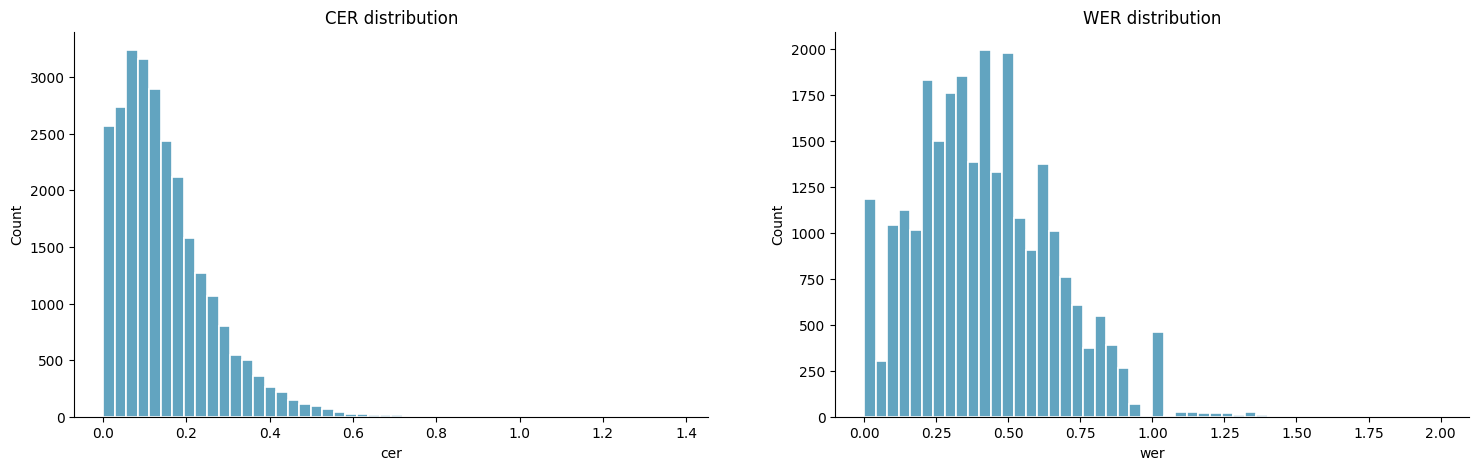

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.histplot(
    data=merged_results, 
    ax=ax[0], x='cer', 
    bins=50, color='#2E86AB',
    edgecolor='white', linewidth=1.2
)
ax[0].set_title("CER distribution")
sns.histplot(
    data=merged_results, 
    ax=ax[1], x='wer', 
    bins=50, color='#2E86AB',
    edgecolor='white', linewidth=1.2
)
ax[1].set_title("WER distribution");

In [33]:
show_prediction_examples(merged_results)


🔍 CER = 0 (very good) (1190 samples):
True: champions were west germany who won their second title
Pred: champions were west germany who won their second title
CER: 0.000
Accent: United States English
----------------------------------------
True: the station site is now part of the manifold way
Pred: the station site is now part of the manifold way
CER: 0.000
Accent: United States English
----------------------------------------
True: single copy voice
Pred: single copy voice
CER: 0.000
Accent: United States English
----------------------------------------
True: he has incorporated this knowledge into the groups sound and recording techniques
Pred: he has incorporated this knowledge into the groups sound and recording techniques
CER: 0.000
Accent: United States English
----------------------------------------

🔍 CER < 0.1 (good) (9234 samples):
True: in such proteins the pigments are arranged to work together
Pred: in such proteins the pagments are arranged to work together
CER: 0.01

## Mixed accents (model trained only on USA accent)

In [129]:
test_dataset, idxs = create_dataset_with_indices(*load_data_with_indices("data/CommonVoice/balanced_test.h5"))
test_data_size = len(idxs)
loss = round(model.evaluate(test_dataset, verbose=1, steps=test_data_size//BATCH_SIZE), 2)
print("Loss:", loss)
results = predict_with_indices(test_dataset, model, idxs, num_to_char)

data = pd.read_csv("balanced_dataset.csv")
analysis_df, merged_results = analyze_results_by_accent(results, data)
analysis_df.sort_values(by="CER", ascending=True)

Loss: 55.87


,N_samples,CER,WER,CER_std,WER_std,% no error,% error,perfect_predictions,min_CER,max_CER,min_WER,max_WER
United States English,3668,0.12,0.37,0.10,0.23,0.07,0.93,239,0.00,0.71,0.00,1.67
Canadian English,3668,0.14,0.40,0.11,0.24,0.04,0.96,159,0.00,1.00,0.00,1.80
England English,3669,0.26,0.61,0.12,0.23,0.01,0.99,19,0.00,0.91,0.00,2.00
Australian English,3668,0.28,0.64,0.13,0.23,0.00,1.00,11,0.00,0.89,0.00,2.00
"Southern African (South Africa, Zimbabwe, Namibia)",3669,0.39,0.78,0.14,0.23,0.00,1.00,3,0.00,1.00,0.00,3.00
"India and South Asia (India, Pakistan, Sri Lanka)",3669,0.39,0.78,0.14,0.22,0.00,1.00,4,0.00,1.00,0.00,2.00


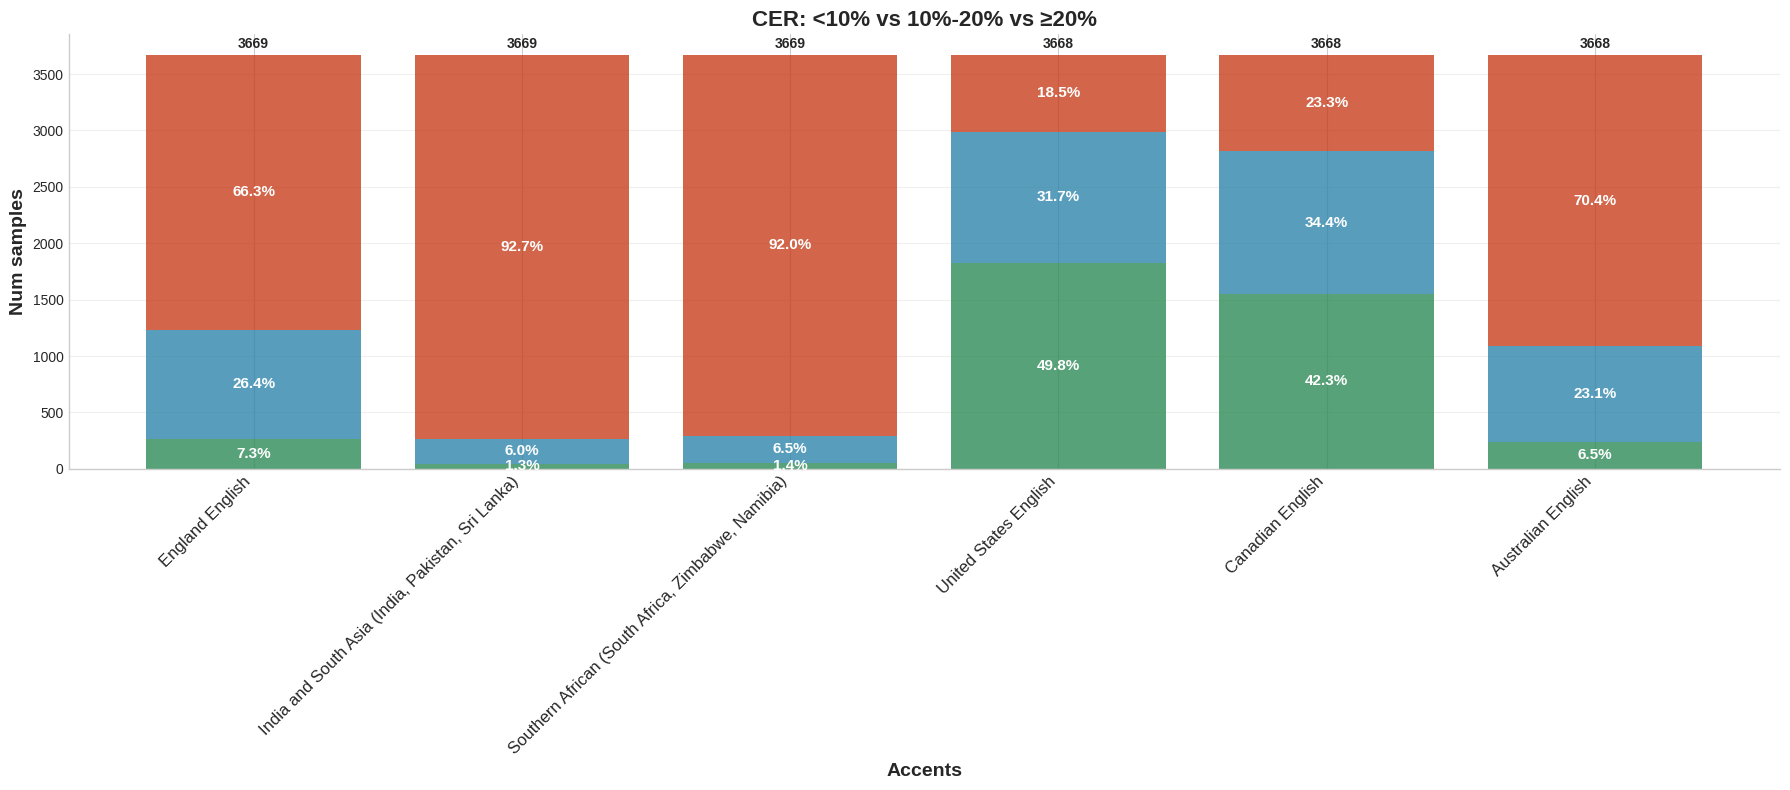

,Accent,Total_samples,CER_below_10%,CER_10_to_20%,CER_above_20%,Percent_below_10%,Percent_10_to_20%,Percent_above_20%
0,England English,3669,267,968,2434,7.28,26.38,66.34
1,"India and South Asia (India, Pakistan, Sri Lanka)",3669,47,221,3401,1.28,6.02,92.70
2,"Southern African (South Africa, Zimbabwe, Nami...",3669,53,239,3377,1.44,6.51,92.04
3,United States English,3668,1828,1162,678,49.84,31.68,18.48
4,Canadian English,3668,1551,1263,854,42.28,34.43,23.28
5,Australian English,3668,240,846,2582,6.54,23.06,70.39


In [132]:
stats = plot_cer_errors(analysis_df, merged_results, threshold1=0.1, threshold2=0.2, legend=False, figsize=(18, 8))
display(stats.round(2))

# Mixed accents models

## Balanced dataset (stratified by accents)

In [160]:
model = tf.keras.models.load_model("mixed_acc_balanced.keras")

In [161]:
test_dataset, idxs = create_dataset_with_indices(*load_data_with_indices("data/CommonVoice/balanced_test.h5"))
test_data_size = len(idxs)
loss = round(model.evaluate(test_dataset, verbose=1, steps=test_data_size//BATCH_SIZE), 2)
print("Loss:", loss)
results = predict_with_indices(test_dataset, model, idxs, num_to_char)

data = pd.read_csv("balanced_dataset.csv")
analysis_df, merged_results = analyze_results_by_accent(results, data)
analysis_df.sort_values(by="CER", ascending=True)

171/171 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - loss: 46.9182
Loss: 47.19
Proceeded 128/22011 samples (batch 0)
Proceeded 6528/22011 samples (batch 50)
Proceeded 12928/22011 samples (batch 100)
Proceeded 19328/22011 samples (batch 150)


,N_samples,CER,WER,CER_std,WER_std,% no error,% error,perfect_predictions,min_CER,max_CER,min_WER,max_WER
Canadian English,3668,0.17,0.48,0.11,0.24,0.02,0.98,77,0.00,0.89,0.00,1.75
United States English,3668,0.21,0.56,0.12,0.24,0.01,0.99,33,0.00,0.68,0.00,1.75
England English,3669,0.22,0.56,0.12,0.24,0.01,0.99,36,0.00,1.00,0.00,1.67
Australian English,3668,0.22,0.58,0.12,0.23,0.01,0.99,24,0.00,0.77,0.00,1.67
"Southern African (South Africa, Zimbabwe, Namibia)",3669,0.25,0.59,0.13,0.24,0.01,0.99,29,0.00,0.95,0.00,2.50
"India and South Asia (India, Pakistan, Sri Lanka)",3669,0.29,0.67,0.12,0.21,0.00,1.00,7,0.00,0.89,0.00,2.00


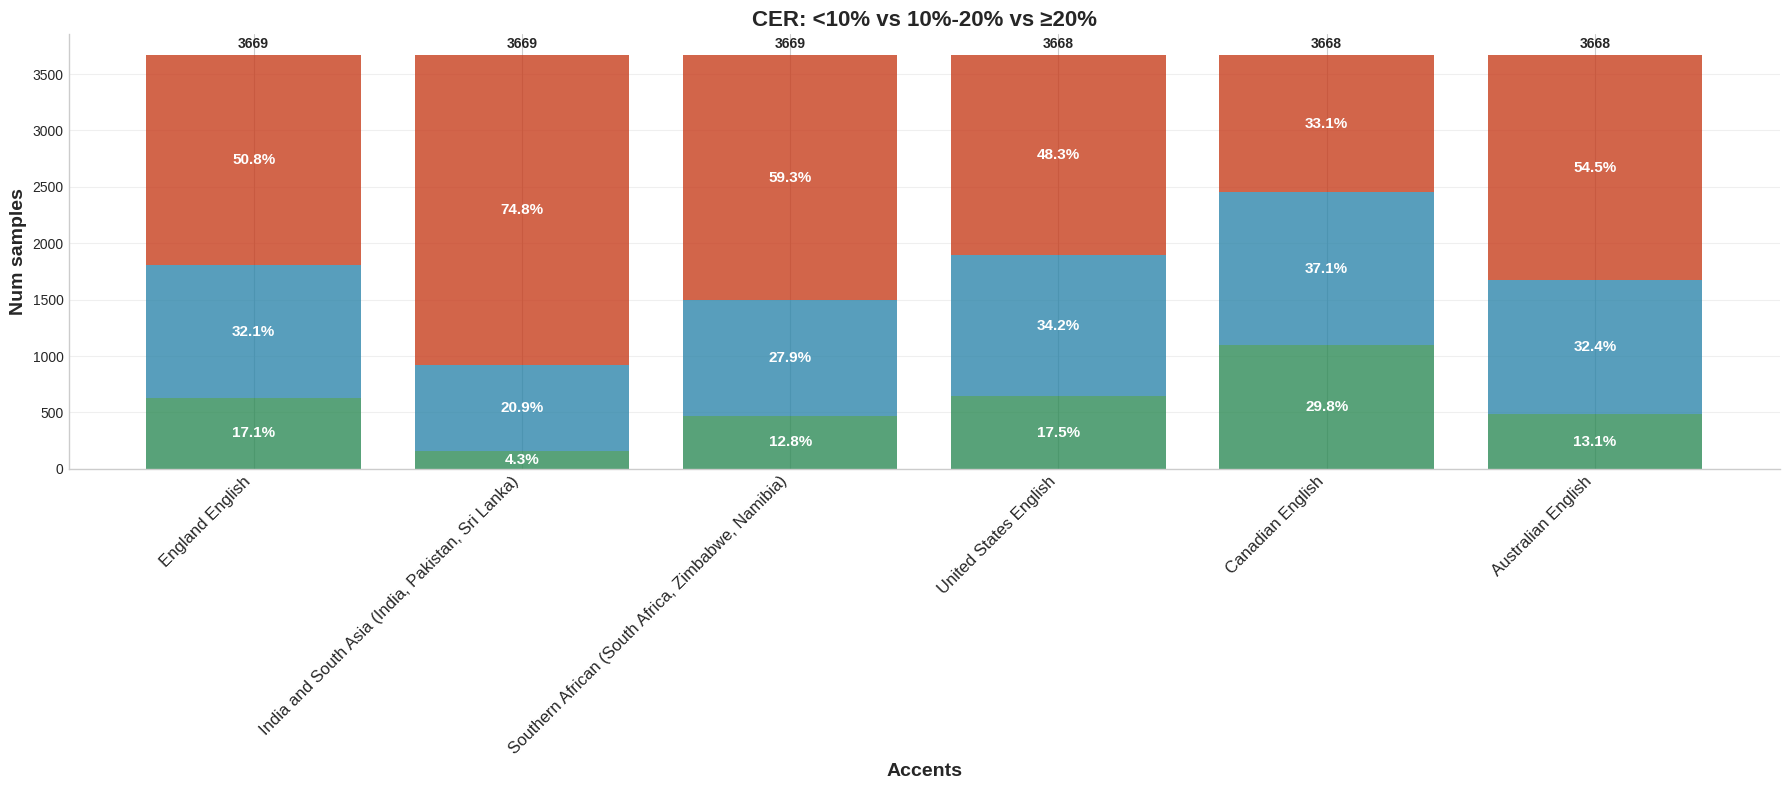

,Accent,Total_samples,CER_below_10%,CER_10_to_20%,CER_above_20%,Percent_below_10%,Percent_10_to_20%,Percent_above_20%
0,England English,3669,629,1176,1864,17.14,32.05,50.80
1,"India and South Asia (India, Pakistan, Sri Lanka)",3669,157,766,2746,4.28,20.88,74.84
2,"Southern African (South Africa, Zimbabwe, Nami...",3669,469,1024,2176,12.78,27.91,59.31
3,United States English,3668,643,1255,1770,17.53,34.21,48.26
4,Canadian English,3668,1094,1361,1213,29.83,37.10,33.07
5,Australian English,3668,482,1188,1998,13.14,32.39,54.47


In [136]:
stats = plot_cer_errors(analysis_df, merged_results, threshold1=0.1, threshold2=0.2, legend=False, figsize=(18, 8))
display(stats.round(2))

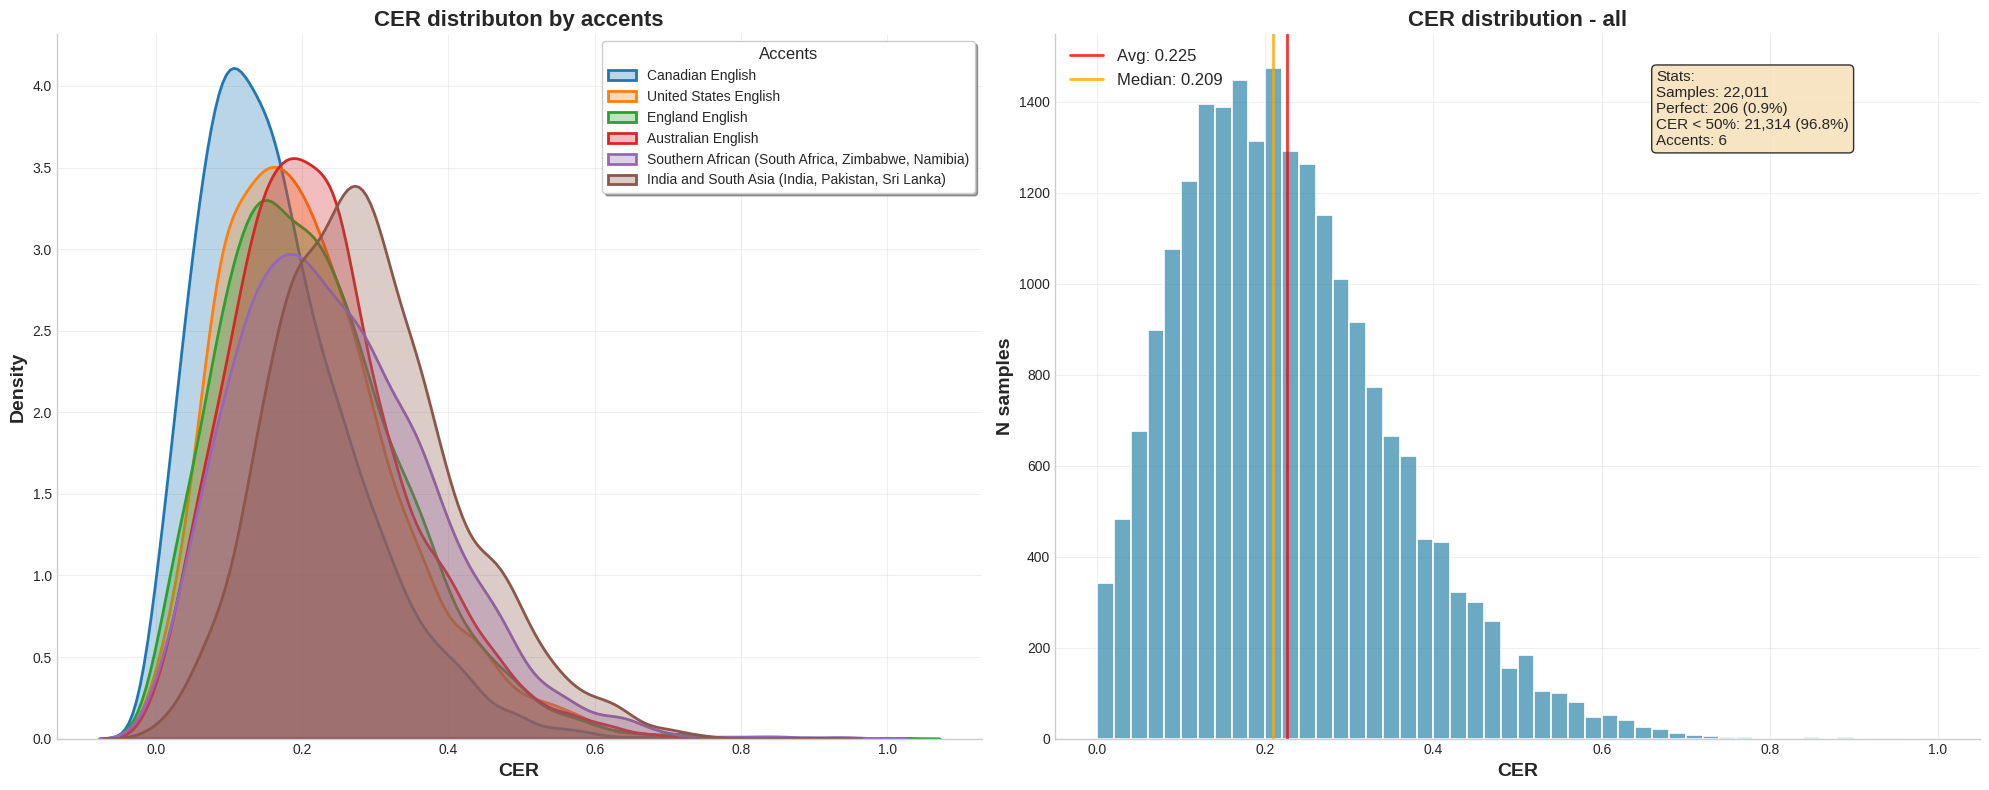

In [164]:
plot_cer_distributions(merged_results, analysis_df, title1='CER distributon by accents')

In [165]:
show_prediction_examples(merged_results)


🔍 CER = 0 (very good) (206 samples):
True: this is their identity
Pred: this is their identity
CER: 0.000
Accent: Southern African (South Africa, Zimbabwe, Namibia)
----------------------------------------
True: this is known as frequency capping
Pred: this is known as frequency capping
CER: 0.000
Accent: Australian English
----------------------------------------
True: the series has been adapted into two manga series
Pred: the series has been adapted into two manga series
CER: 0.000
Accent: Canadian English
----------------------------------------
True: it was fun
Pred: it was fun
CER: 0.000
Accent: Australian English
----------------------------------------

🔍 CER < 0.1 (good) (3268 samples):
True: it was however censored by some radio stations
Pred: it was however sensored by sobradio stations
CER: 0.087
Accent: United States English
----------------------------------------
True: along the coast is the church of saint jerome
Pred: along the coast is the church of saint geron
CER: 

## Unbalanced accents dataset

In [148]:
model = tf.keras.models.load_model("mixed_acc_unabalanced.keras")

In [141]:
test_dataset, idxs = create_dataset_with_indices(*load_data_with_indices("data/CommonVoice/unbalanced_test.h5"))
test_data_size = len(idxs)
loss = round(model.evaluate(test_dataset, verbose=1, steps=test_data_size//BATCH_SIZE), 2)
print("Loss:", loss)
results = predict_with_indices(test_dataset, model, idxs, num_to_char)

data = pd.read_csv("unbalanced_dataset.csv")
analysis_df, merged_results = analyze_results_by_accent(results, data)
analysis_df.sort_values(by="CER", ascending=True)

166/166 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - loss: 47.1227
Loss: 47.76
Proceeded 128/21309 samples (batch 0)
Proceeded 6528/21309 samples (batch 50)
Proceeded 12928/21309 samples (batch 100)
Proceeded 19328/21309 samples (batch 150)


,N_samples,CER,WER,CER_std,WER_std,% no error,% error,perfect_predictions,min_CER,max_CER,min_WER,max_WER
Northern Irish,1153,0.12,0.40,0.08,0.21,0.04,0.96,43,0.00,0.67,0.00,1.50
"Non native speaker,German English",2000,0.12,0.39,0.07,0.20,0.03,0.97,51,0.00,0.66,0.00,1.33
Canadian English,2000,0.18,0.51,0.11,0.23,0.01,0.99,29,0.00,0.79,0.00,2.50
"England English,New Zealand English",471,0.19,0.55,0.10,0.22,0.01,0.99,3,0.00,0.67,0.00,1.33
New Zealand English,1066,0.20,0.55,0.11,0.23,0.00,1.00,5,0.00,0.68,0.00,1.50
United States English,2000,0.22,0.58,0.11,0.24,0.01,0.99,24,0.00,0.74,0.00,1.67
England English,2000,0.22,0.58,0.12,0.24,0.01,0.99,23,0.00,0.76,0.00,1.40
Irish English,1010,0.23,0.60,0.13,0.24,0.01,0.99,8,0.00,0.65,0.00,1.43
Australian English,2000,0.24,0.61,0.12,0.23,0.00,1.00,7,0.00,0.81,0.00,1.60
"United States English,England English",483,0.25,0.64,0.12,0.24,0.00,1.00,2,0.00,0.70,0.00,2.00


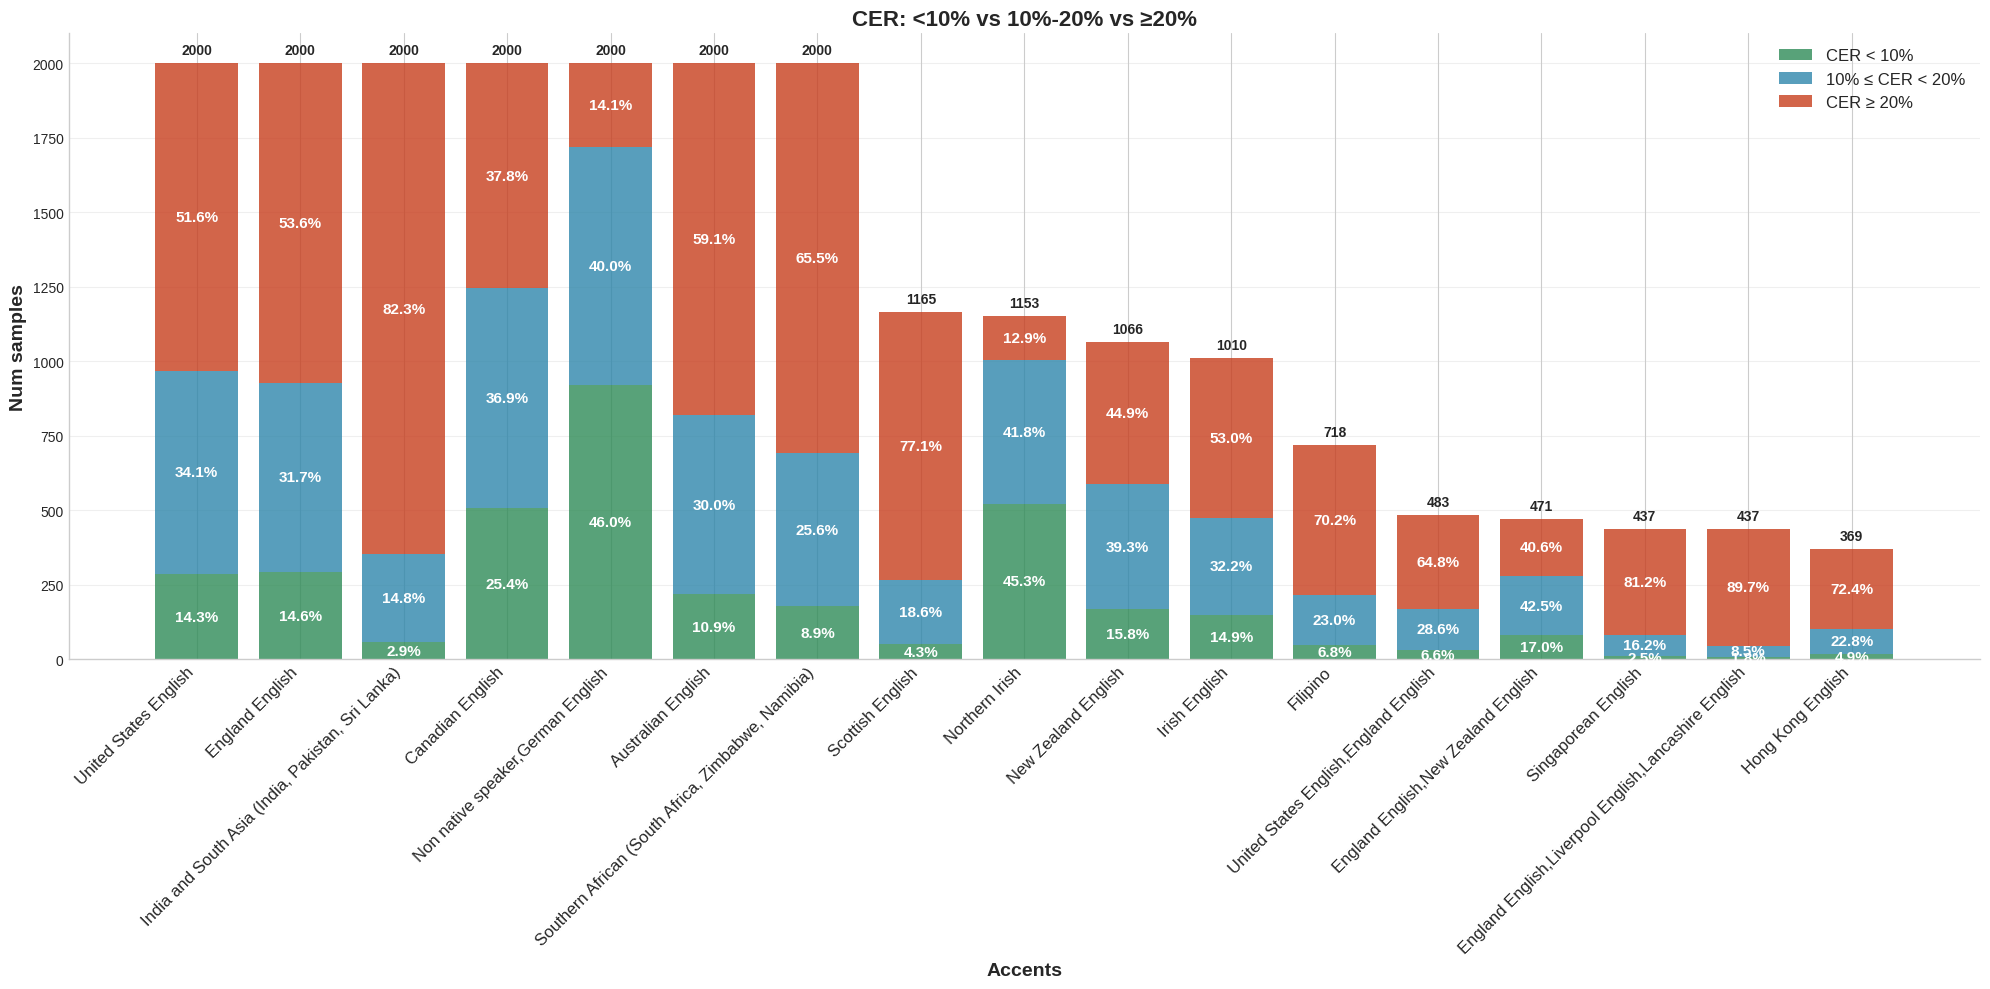

,Accent,Total_samples,CER_below_10%,CER_10_to_20%,CER_above_20%,Percent_below_10%,Percent_10_to_20%,Percent_above_20%
0,United States English,2000,287,681,1032,14.35,34.05,51.60
1,England English,2000,293,634,1073,14.65,31.70,53.65
2,"India and South Asia (India, Pakistan, Sri Lanka)",2000,58,295,1647,2.90,14.75,82.35
3,Canadian English,2000,508,737,755,25.40,36.85,37.75
4,"Non native speaker,German English",2000,919,800,281,45.95,40.00,14.05
5,Australian English,2000,218,601,1181,10.90,30.05,59.05
6,"Southern African (South Africa, Zimbabwe, Nami...",2000,179,512,1309,8.95,25.60,65.45
7,Scottish English,1165,50,217,898,4.29,18.63,77.08
8,Northern Irish,1153,522,482,149,45.27,41.80,12.92
9,New Zealand English,1066,168,419,479,15.76,39.31,44.93


In [147]:
stats = plot_cer_errors(analysis_df, merged_results, threshold1=0.1, threshold2=0.2, legend=True, figsize=(20, 10))
display(stats.round(2))

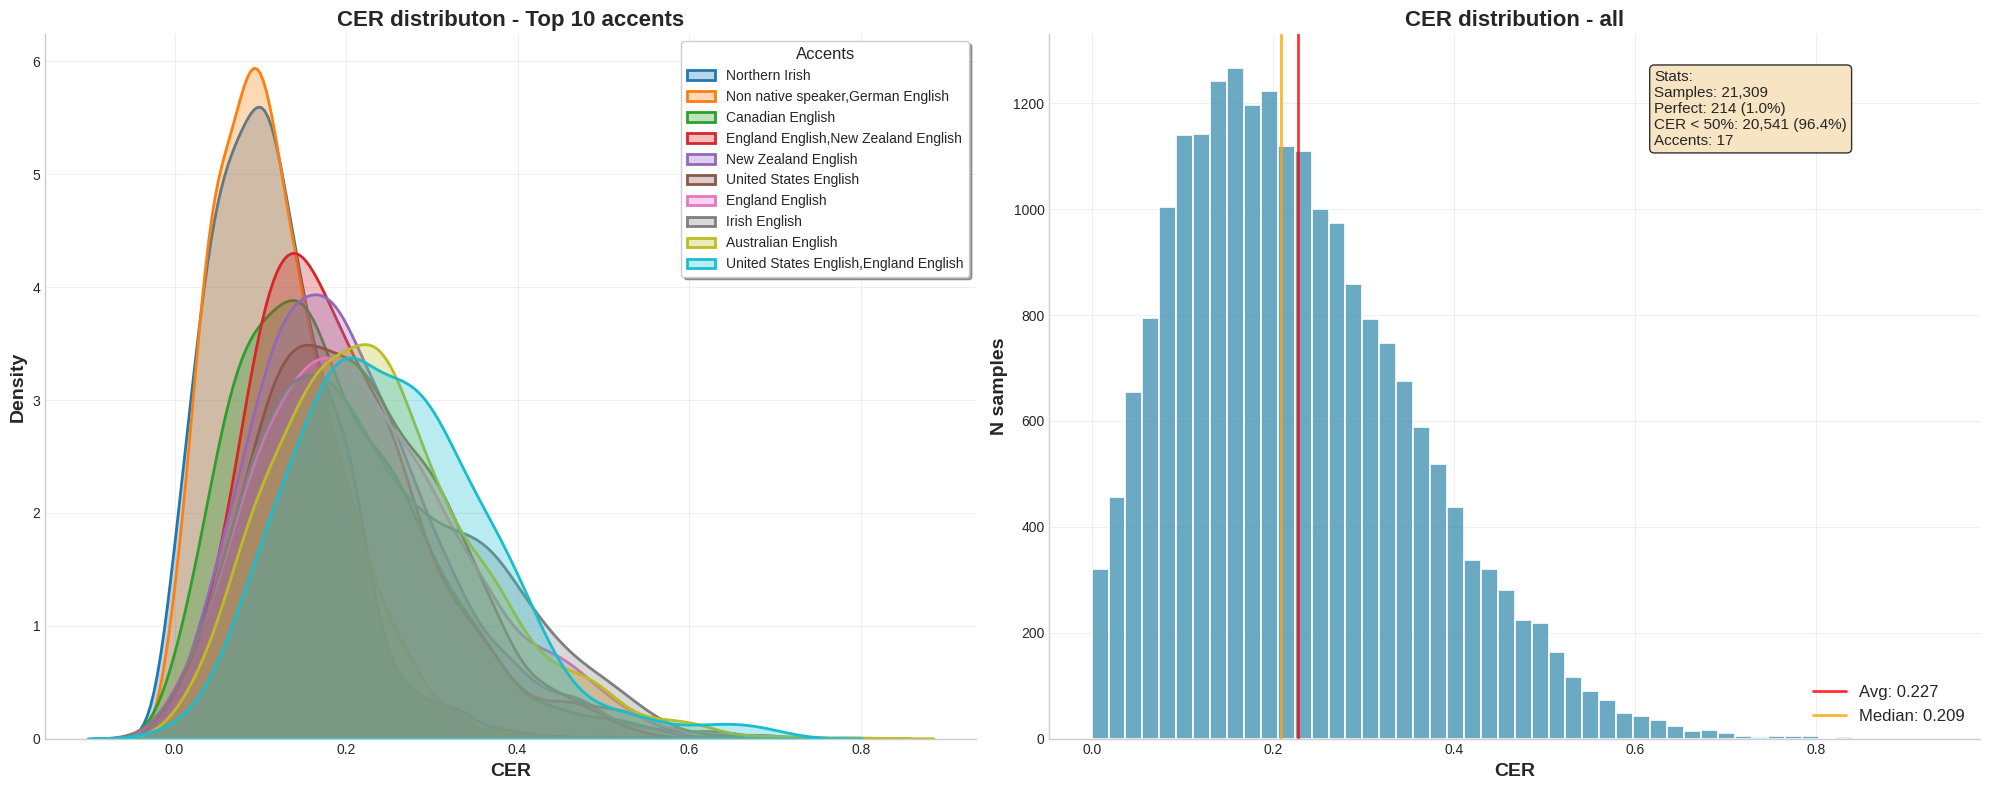

In [158]:
plot_cer_distributions(merged_results, analysis_df)

In [154]:
show_prediction_examples(merged_results)


🔍 CER = 0 (very good) (214 samples):
True: the station was located on two different sites during its history
Pred: the station was located on two different sites during its history
CER: 0.000
Accent: Northern Irish
----------------------------------------
True: the park is open yearround
Pred: the park is open yearround
CER: 0.000
Accent: Irish English
----------------------------------------
True: like spam it is often fried or baked before consumption
Pred: like spam it is often fried or baked before consumption
CER: 0.000
Accent: England English
----------------------------------------
True: he also worked on jellyfish
Pred: he also worked on jellyfish
CER: 0.000
Accent: Australian English
----------------------------------------

🔍 CER < 0.1 (good) (3336 samples):
True: in the oppressive circumstances he would not perform for four years
Pred: in the opressive circumstancis he would not performe for four years
CER: 0.045
Accent: Non native speaker,German English
-------------------